# Example 1

This example aims to show the usage of the decisiorama tool for solving MCDA problems. This example is based on the paper of Lahtinen 2007.



In [65]:
# import required libraries for this example
import sys
sys.path.insert(0, '..')

import numpy as np  # For array manipulation
import itertools  # For generating the portfolios
import matplotlib.pyplot as plt  # for visualising the results

import decisiorama
from decisiorama.pda.preference import Objective, Evaluator
from decisiorama.pda import utility, aggregate, ranker

## Defining the 

Here we define the solutions. For each leaf objective, 

In [66]:
# Define the value for each of the model attributes

# Phosporous
p = np.array([[0.9, 1.1],
              [1.1, 1.3],
              [1.3, 1.7],
              [0.0, 0.0],
              [0.0, 0.0],
              [0.0, 0.0],
              [0.5, 0.6],
              [0.0, 0.0],
              [4.0, 4.8],])

# Nitrates
n2 = np.array([[0.09, 0.11],
               [0.09, 0.11],
               [0.14, 0.17],
               [0.00, 0.00],
               [0.00, 0.00],
               [0.00, 0.00],
               [0.00, 0.00],
               [0.00, 0.00],
               [0.40, 0.48],])

# Climate
climate = np.array([[0.0, 0.0],
                    [0.0, 0.0],
                    [0.5, 1.5],
                    [-1.5, -0.5],
                    [0.0, 0.0],
                    [0.5, 1.5],
                    [0.0, 0.0],
                    [0.0, 0.0],
                    [-2.5, -1.5],])

# Savings
savings = np.array([[1.8, 2.2],
                    [1.8, 2.2],
                    [1.8, 2.2],
                    [1.8, 2.2],
                    [0.9, 1.1],
                    [9.0, 11.0],
                    [32.0, 40.0],
                    [14.0, 18.0],
                    [3.5, 4.5],])

# Overall - These will be calculated
overall = None

# Create of a dictionary with the attributes
attributes = dict(p = p, 
                  n2 = n2, 
                  climate = climate, 
                  savings = savings, 
                  overall = overall,
                 )

In [67]:
# Define the number of random samlpes to draw for the Monte Carlo experiment
n = 100

obj_p = Objective(
        name = 'p',
        w = 0.25,
        alternatives = attributes['p'], 
        obj_min = 0.0, 
        obj_max = 4.8, 
        n = n, 
        utility_func = utility.exponential, 
        utility_pars = [0.0, ], 
        aggregation_func = aggregate.additive, 
        aggregation_pars = None,
        maximise = True)

obj_n2 = Objective(
        name = 'n2',
        w = 0.25,
        alternatives = attributes['n2'], 
        obj_min = 0.0, 
        obj_max = 0.48, 
        n = n, 
        utility_func = utility.exponential, 
        utility_pars = [0.0, ], 
        aggregation_func = aggregate.additive, 
        aggregation_pars = None,
        maximise = True)

obj_climate = Objective(
        name = 'climate',
        w = 0.25,
        alternatives = attributes['climate'][:], 
        obj_min = -2.5, 
        obj_max = 1.5, 
        n = n, 
        utility_func = utility.exponential, 
        utility_pars = [0.0, ], 
        aggregation_func = aggregate.additive, 
        aggregation_pars = None,
        maximise = True)

obj_savings = Objective(
        name = 'savings',
        w = 0.25,
        alternatives = attributes['savings'], 
        obj_min = 0.9, 
        obj_max = 40.0, 
        n = n, 
        utility_func = utility.exponential, 
        utility_pars = [0.0, ], 
        aggregation_func = aggregate.additive, 
        aggregation_pars = None,
        maximise = True)

obj_overall = Objective(
        name = 'overall',
        w = 0.25,
        alternatives = attributes['overall'], 
        obj_min = 0.0, 
        obj_max = 1.0, 
        n = n, 
        utility_func = utility.exponential, 
        utility_pars = 0.0, 
        aggregation_func = aggregate.additive, 
        aggregation_pars = None,
        maximise = True)

In [68]:
# Build the objectives hierarchy
obj_overall.add_children(obj_p)
obj_overall.add_children(obj_n2)
obj_overall.add_children(obj_climate) 
obj_overall.add_children(obj_savings)

# test the problem solutions
x = [1,1,1,1,1,1,1,1,1]
obj_overall.get_value(x)

array([0.75   , 0.96875])

In [69]:
# Define the problem limits
costs = [1.0, 1.0, 2.0, 10.0, 8.0, 11.0, 43.0, 23.0, 20.0]
water = [0.03, 0.07, 0.04, 0.015, 0.10, 0.38, 0.15, 0.34, 0.46]
budget_limit = 45.0

# Make function to filter out the infeasible portfolios
def filter_inps(inps):
    '''
    inps : list, int
        Contains the portfolios. 1 represents the action is carried out, while 0 means the action is not.
    '''
    out = []
    
    def follow_up(pred, post):
        '''Test if the post action is a follow-up from the predecesor'''
        if post:
            if not pred:
                return False
        return True
        
    def mutual_exclusive(a, b):
        '''Test for mutual exclusivity'''
        if a and b:
            return False
        return True

    for x in inps:
    
        # add the constraint of a follow up action
        if not follow_up(x[3], x[4]):
            continue
        
        # add the constraint of a mutually exclusive action
        if not mutual_exclusive(x[3], x[5]):
            continue
        
        if not mutual_exclusive(x[6], x[7]):
            continue
        
        if not mutual_exclusive(x[6], x[8]):
            continue
     
        # add budget and water savings constraints
        budget = np.sum([a for i, a in enumerate(costs) if x[i]]) 
        if budget > budget_limit:
            continue
    
        water_target = 1.0 - np.prod([(1.0 - a) for i, a in enumerate(water) if x[i]])
        if water_target < 0.5:
            continue
        
        out.append(x)
    return out

# generate the potential portfolios
inp_comb = list(itertools.product([0, 1], repeat=len(x)))  # Make all possible combinations of portfolios
inps = np.array(filter_inps(inp_comb))  # Eliminate unfeasible portfolios
res = np.array(list(map(obj_overall.get_value, inps)))  # obtain the results for the feasible portfolios


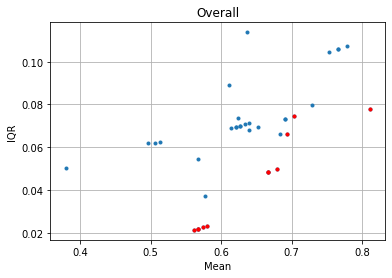

In [70]:
# Evaluate the solutions
ee = Evaluator(inps, res)  # initialise the Evaluator class with the portfolios and results
ee.add_function(ranker.mean, minimize=False)  # add the maximum mean objective function
ee.add_function(ranker.iqr, minimize=True)  # add the minimum inter-quantile range objective function

# obtain the pareto solutions
par_sols = ee.get_pareto_solutions()

# Plot the pareto solutions for the overall objective
plt.plot(ranker.mean(res), ranker.iqr(res), '.')
plt.plot(ranker.mean(res)[par_sols], ranker.iqr(res)[par_sols], '.r')
plt.title('Overall')
plt.xlabel('Mean')
plt.ylabel('IQR')
plt.grid()
plt.show()

In [71]:
res



array([[0.52280477, 0.70060742],
       [0.52208546, 0.74960038],
       [0.32880435, 0.42966752],
       [0.45055413, 0.57536765],
       [0.64889706, 0.80842391],
       [0.64817775, 0.85741688],
       [0.5121883 , 0.62081735],
       [0.54539642, 0.68318414],
       [0.61764706, 0.71467391],
       [0.61692775, 0.76366688],
       [0.44447997, 0.56873402],
       [0.53964194, 0.5824009 ],
       [0.54539642, 0.58943414],
       [0.57089194, 0.7074009 ],
       [0.6596867 , 0.87148338],
       [0.62786392, 0.75988384],
       [0.5511509 , 0.69021739],
       [0.55690537, 0.69725064],
       [0.61764706, 0.71467391],
       [0.61692775, 0.76366688],
       [0.4340633 , 0.55831735],
       [0.54539642, 0.58943414],
       [0.6596867 , 0.87148338],
       [0.61744725, 0.74946718],
       [0.5511509 , 0.69021739],
       [0.55690537, 0.69725064],
       [0.53964194, 0.6136509 ],
       [0.62915601, 0.72874041],
       [0.6284367 , 0.77773338],
       [0.54973892, 0.69738384],
       [0.